In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from tqdm import tqdm

In [2]:
# reading preprocessed data

df = pd.read_csv("preprocessed1.csv")

## Generating wordclouds

In [3]:
df1 = df[df['is_duplicate'] == 1]
df2 = df[df['is_duplicate'] == 0]

d = np.dstack([df1["question1"], df1["question2"]]).flatten()
nd = np.dstack([df2["question1"], df2["question2"]]).flatten()

np.savetxt('duplicate.txt', d, delimiter=' ', fmt='%s')
np.savetxt('not_duplicate.txt', nd, delimiter=' ', fmt='%s')

In [4]:
file1 = open('duplicate.txt', 'r').read()
file2 = open('not_duplicate.txt', 'r').read()

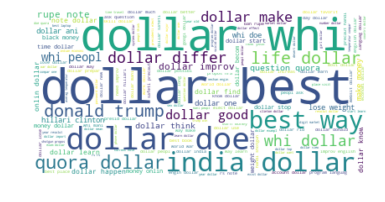

In [5]:
# wordcloud of words in duplicate.txt

wc = WordCloud(background_color="white")
wc.generate(file1)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

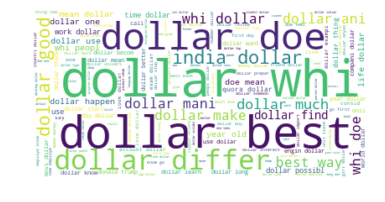

In [6]:
# wordcloud of words in not_duplicate.txt

wc = WordCloud(background_color="white")
wc.generate(file2)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## tf-idf weighted word2vec

In [7]:
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [8]:
nlp = spacy.load('en_core_web_sm')

vec1_mean = []
vec2_mean = []

for ques1, ques2 in tqdm(zip(df["question1"].values, df["question2"].values)):
    vec1 = np.zeros(384)
    vec2 = np.zeros(384)
    
    for word1 in ques1.split():
        tfidf_vec1 = (nlp(word1).vector) * word2tfidf[word1]
        vec1 = vec1 + tfidf_vec1
       
    for word2 in ques2.split():
        tfidf_vec2 = (nlp(word2).vector) * word2tfidf[word2]
        vec2 = vec2 + tfidf_vec2  
        
    mean_vec1 = vec1/len(ques1.split()) 
    mean_vec2 = vec2/len(ques2.split())
    
    vec1_mean.append(mean_vec1)
    vec2_mean.append(mean_vec2)

404287it [11:00:28, 10.20it/s]


In [24]:
arr1 = np.array(vec1_mean)
arr2 = np.array(vec2_mean)

In [25]:
df_question1 = pd.DataFrame(arr1)
df_question2 = pd.DataFrame(arr2)

In [26]:
df_concat = pd.concat([df, df_question1, df_question2], axis=1)

In [27]:
df_concat.shape

(404287, 814)

In [28]:
df_final = df_concat.drop(['qid1','qid2','question1', 'question2'], axis=1)
df_final.head()

,id,is_duplicate,freq_q1,freq_q2,freq_q1 + freq_q2,freq_q1 - freq_q2,q1_len,q2_len,t_common,t_total,...,374,375,376,377,378,379,380,381,382,383
0,0,0,1,1,2,0,71.0,62.0,12.0,28.0,...,2.531312,5.241165,-1.036594,-1.256495,2.527618,-0.449197,-2.342918,-1.382626,1.852207,-1.332803
1,1,0,4,1,5,3,53.0,86.0,7.0,25.0,...,4.219047,5.050595,0.553851,-0.851368,-0.386970,-1.718210,0.396399,-1.704200,0.592108,0.057426
2,2,0,1,1,2,0,69.0,60.0,6.0,24.0,...,0.125580,2.148327,-0.504118,-2.026047,0.240076,0.208126,-1.862247,-2.112072,1.385388,-0.080224
3,3,0,1,1,2,0,46.0,50.0,1.0,20.0,...,3.499286,3.486958,0.078194,-2.426378,0.556657,-1.305460,-1.149844,-2.170979,3.166841,-0.286454
4,4,0,3,1,4,2,75.0,44.0,5.0,22.0,...,0.794510,4.096482,0.209771,-2.323336,-0.210882,-0.748318,-1.404563,-1.473576,2.107732,-1.404485


In [29]:
df_final.to_csv("preprocessed2.csv", index = False)